In [45]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import regex as re
from typing import List, Optional, Dict, Tuple

import msgspec
from tqdm import tqdm
from loguru import logger
from dacite import from_dict

from common.constants import SYSTEM_PROMPT_FPG, CORE_OPTIONS
from common.utils import remove_comments, replace_sorry, replace_calc, remove_multiline_comments, remove_singleline_comments
from common.pantograph.dataclasses import ProblemGenerationProcess, ProblemGenerationStep, Variable, normalize_draft, replace_span, Goal
from common.pantograph.server import PersistentServer, TacticFailure, ServerError


In [46]:
def print_xtuner_sample(data: list):
    if 'system' in data['conversation'][0].keys():
        print('<SYSTEM>')
        print(data['conversation'][0]['system'])
        print('</SYSTEM>')
    print('<INPUT>')
    print(data['conversation'][0]['input'])
    print('</INPUT>\n<OUTPUT>')
    print(data['conversation'][0]['output'])
    print('</OUTPUT>')


In [47]:
base_dir = '/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/deductive_transformation'
data = []

for i in tqdm(list(range(41))):
    with open(osp.join(base_dir, f'done_v2_chunk_{1024*i}.pkl'), 'rb') as f:
        data.extend(pickle.load(f))

100%|██████████| 41/41 [01:32<00:00,  2.26s/it]


### Data Analysis

In [48]:
data_parsed = [d for d in data if d is not None]
assert all('parse_result' in d.keys() for d in data_parsed)
print(len(data), len(data_parsed), len(data)-len(data_parsed))

41109 39840 1269


In [49]:
n_total_units = 0
n_transformed_units = 0
for d in data_parsed:
    units = d['parse_result']['units']
    all_parsed_units = [i_u for i_u, u in enumerate(units) if len(u['invocations'] or []) > 0]
    n_total_units += len(all_parsed_units)
    n_transformed_units += len([i_u for i_u in all_parsed_units if 'deductive_steps' in units[i_u].keys()])
print(n_total_units, n_transformed_units, n_total_units-n_transformed_units)

41543 40069 1474


### Data Composition - Deductive Proof Generation

In [50]:
proof_lengths = []
for d in data_parsed:
    for u in d['parse_result']['units']:
        if 'deductive_steps' in u.keys():
            assert len(u['invocations'] or []) > 0
            proof_lengths.append(len(u['deductive_steps']))

In [51]:
C.Counter(proof_lengths)

Counter({2: 18721,
         3: 4766,
         4: 3252,
         5: 2733,
         6: 2398,
         7: 1781,
         8: 1504,
         9: 1065,
         10: 919,
         11: 681,
         12: 549,
         13: 359,
         14: 292,
         15: 216,
         16: 166,
         17: 148,
         18: 93,
         19: 75,
         20: 60,
         22: 43,
         21: 38,
         23: 36,
         24: 31,
         27: 21,
         26: 21,
         25: 15,
         28: 9,
         32: 9,
         29: 7,
         36: 6,
         34: 6,
         44: 5,
         39: 5,
         30: 5,
         1: 5,
         33: 4,
         37: 3,
         35: 3,
         42: 2,
         55: 2,
         40: 2,
         31: 2,
         49: 2,
         52: 2,
         53: 1,
         51: 1,
         77: 1,
         54: 1,
         38: 1,
         46: 1,
         65: 1})

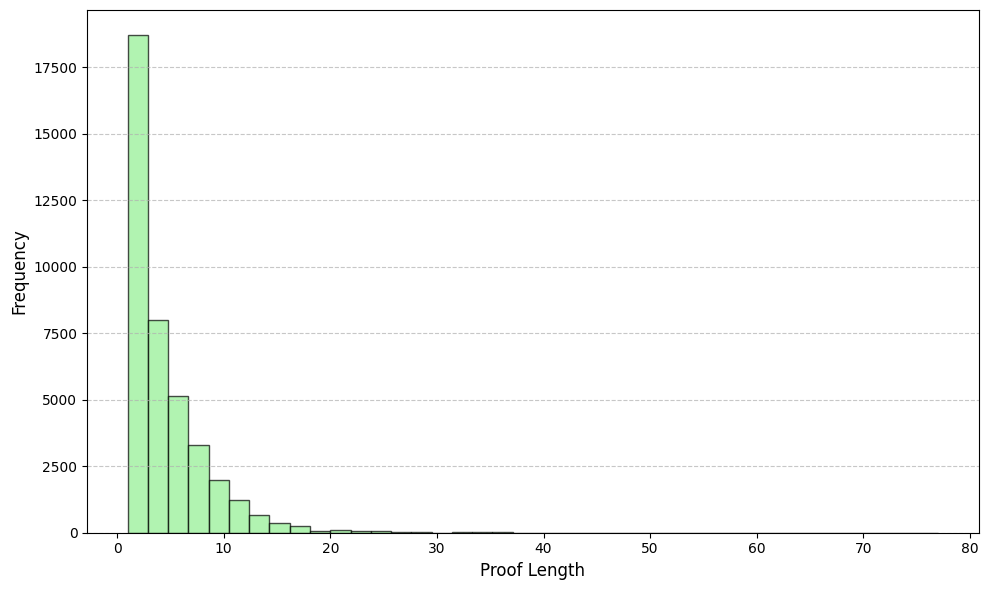

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# bins: Number of intervals to group integers (adjust based on your data range)
plt.hist(proof_lengths, bins=40, color='lightgreen', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Proof Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [53]:
data_deductive_proof_generation = []

In [54]:
header = ("""
import Mathlib
import Aesop

""" + '\n'.join('set_option ' + t.replace('=', ' ') for t in CORE_OPTIONS)).strip()
print(header)

import Mathlib
import Aesop

set_option maxHeartbeats 0
set_option maxRecDepth 100000
set_option tactic.hygienic false
set_option pp.fullNames true
set_option pp.funBinderTypes true
set_option pp.piBinderTypes true


In [55]:
for d in data_parsed:
    for u in d['parse_result']['units']:
        if 'deductive_steps' in u.keys():
            assert len(u['invocations'] or []) > 0
            
            init_state = u['deductive_states'][0]
            assert len(init_state) == 1
            init_state = from_dict(Goal, init_state[0])
            
            whole_proof = u['whole_proof']
            if whole_proof is None:
                # There is only one `whole_proof is None`, and is manually validated by Qi
                whole_proof = ''
                for t, s in u['deductive_steps']:
                    if len(t) > 0:
                        whole_proof += t
                    whole_proof += s + '\n\n'
                whole_proof = whole_proof.strip()
            
            data_deductive_proof_generation.append({
                "conversation":[
                    {
                        "input": f"""
Assume the following header is executed:
```lean4
{header}
```

Generate a deductive proof for the following Lean 4 proof state:
```lean4
{str(init_state)}
```
""".strip(),
                        "output": whole_proof
                    }
                ]
            })

In [56]:
print_xtuner_sample(random.choice(data_deductive_proof_generation))

<INPUT>
Assume the following header is executed:
```lean4
import Mathlib
import Aesop

set_option maxHeartbeats 0
set_option maxRecDepth 100000
set_option tactic.hygienic false
set_option pp.fullNames true
set_option pp.funBinderTypes true
set_option pp.piBinderTypes true
```

Generate a deductive proof for the following Lean 4 proof state:
```lean4
f : ℝ → ℝ
hf : f = fun (x : ℝ) => √(2 - x) + √(3 * x + 12)
x : ℝ
hx : x ∈ Set.Icc (-4) 2
⊢ f x ∈ Set.Icc (√6) (2 * √6)
```
</INPUT>
<OUTPUT>
rcases hx with ⟨hx1, hx2⟩

open scoped BigOperators in
open Real Set in
have hfx1 : f x = sqrt (2 - x) + sqrt (3 * x + 12) := by rw [hf]

open scoped BigOperators in
open Real Set in
have h1 : sqrt 6 ≤ sqrt (2 - x) + sqrt (3 * x + 12) :=
  by
  have h21 : 0 ≤ (2 - x : ℝ) := by nlinarith
  have h31 : 0 ≤ (3 * x + 12 : ℝ) := by nlinarith
  have h41 : (sqrt (2 - x) + sqrt (3 * x + 12)) ^ 2 ≥ 6 :=
    by
    have h5 :
      (sqrt (2 - x) + sqrt (3 * x + 12)) ^ 2 =
        (sqrt (2 - x)) ^ 2 + (sqrt (3 * x 

In [58]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/deductive_proof_generation.40069.jsonl', 'w') as f:
    for d in data_deductive_proof_generation:
        f.write(json.dumps(d))

### Data Composition - Autoregressive Problem Generation

10240

In [ ]:
print(SYSTEM_PROMPT_FPG)

In [ ]:
def format_step(self):
    if self.proof is None:
        return self.step_draft
    else:
        normalized_step_draft = normalize_draft(self.step_draft)
        matches = list(re.finditer(':= sorry', normalized_step_draft))
        assert len(matches) == len(self.proof)
        for (m, p) in reversed(list(zip(matches, self.proof))):
            normalized_step_draft = replace_span(m.span(), ':= by {\n' + '\n'.join('  ' + l for l in p.splitlines()) + '\n}', normalized_step_draft)
        return normalized_step_draft

In [ ]:
def format_forward_solution_step_prompt(d: ProblemGenerationProcess, state: List[Variable]) -> str:
    context = ''
    vars_to_format = [v for v in state]
    while len(vars_to_format) > 0:
        for i in range(len(vars_to_format)):
            if i + 1 == len(vars_to_format) or not (vars_to_format[i].t == vars_to_format[i+1].t and vars_to_format[i].v is None and vars_to_format[i+1].v is None):
                break
        if i == 0:
            context += str(vars_to_format[0]) + '\n'
            vars_to_format.pop(0)
        else:
            context += ' '.join([v.name if v.name is not None else "_" for v in vars_to_format[:i+1]]) + f' : {vars_to_format[0].t}\n'
            vars_to_format = vars_to_format[i+1:]
    
    prompt = f'''Given a Lean 4 context, propose the single most natural next step to explore toward a beautiful conclusion — either
- derive a new intermediate fact,
- introduce a fresh variable or hypothesis, or
- submit one of the local facts as the final answer.

Requirements
1. Flavoured {d.metainfo['problem_type']} and suitable for posting on forums about {d.metainfo['source']}.
2. Fully formal Lean 4 code (inline comments in natural language are fine for planning and reasoning). Assume `import Mathlib`.


# Lean 4 Context
```lean4
{context.rstrip()}
```
'''
    return prompt


def format_forward_solution_step_response(d: ProblemGenerationProcess, step: ProblemGenerationStep):
    step_type = 'Derive' if step.is_deducing else 'Introduce' if step.is_introducing else 'Submit'
    response = f'''# Step {step_type}
```lean4
{format_step(step).rstrip()}
```
'''
    return response

In [ ]:
data_problem_generation = []

In [ ]:
for d in tqdm(data_nonsynthetic_n15):
    for p in d.trajectory:
        data_problem_generation.append({
            "conversation":[
                {
                    "system": SYSTEM_PROMPT_FPG,
                    "input": format_forward_solution_step_prompt(d, p[0]),
                    "output": format_forward_solution_step_response(d, d.steps[p[1]])
                }
            ]
        })

In [ ]:
len(data_problem_generation)

In [ ]:
with open('/sfs/liuqi/data/AI-MO/NuminaMath-1.5/cycle123_problem_generation_steps.jsonl', 'w') as f:
    for s in data_problem_generation:
        f.write(json.dumps(s) + '\n')

In [ ]:
print(format_forward_solution_step_prompt(d, p[0]))

In [ ]:
print(format_forward_solution_step_response(d, d.steps[p[1]]))